In [ ]:
# !conda install -c mndrake xgboost

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
sns.set_style("dark")
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.grid_search import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample,shuffle
from sklearn import preprocessing
from scipy.stats import probplot
from scipy.stats import skew, boxcox
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import  precision_recall_curve,auc,cohen_kappa_score,average_precision_score

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def drop_columns(df,col_list):
    return df.drop(col_list,1)

In [3]:
def add_binary_col(df,col_orig_name,col_new_name,val):
    df['is'+col_new_name] = df[col_orig_name].apply(lambda row: 1 if row == val else 0)
    return df

In [4]:
def get_stats(df,y_col,y_hat_col):
    tp = df[(df[y_hat_col] == 1) & (df[y_col] == 1)].count()[0]
    fp = df[(df[y_hat_col] == 1) & (df[y_col] == 0)].count()[0]
    tn = df[(df[y_hat_col] == 0) & (df[y_col] == 0)].count()[0]
    fn = df[(df[y_hat_col] == 0) & (df[y_col] == 1)].count()[0]
    accuracy = float(tp+tn) / (tp+tn+fp+fn)
    print 'accuracy:',accuracy
    precision = float(tp) / (tp + fp)
    print 'precision:',precision
    recall = float(tp) / (tp +fn)
    print 'recall:',recall
    f1 = 2 * (precision*recall) / (precision + recall)
    print 'f1:',f1
    f2 = 5 * (precision*recall) / (4*precision + recall)
    print 'f2:',f2
    print 'Kappa :',cohen_kappa_score(df[y_col], df[y_hat_col])
    print "tp : ", tp
    print "tn : ", tn
    print "fp : ", fp
    print "fn : ", fn

# filtered data (without Merchants)

In [5]:
data= pd.read_csv('data.csv')
# df = pd.read_csv('data.csv')

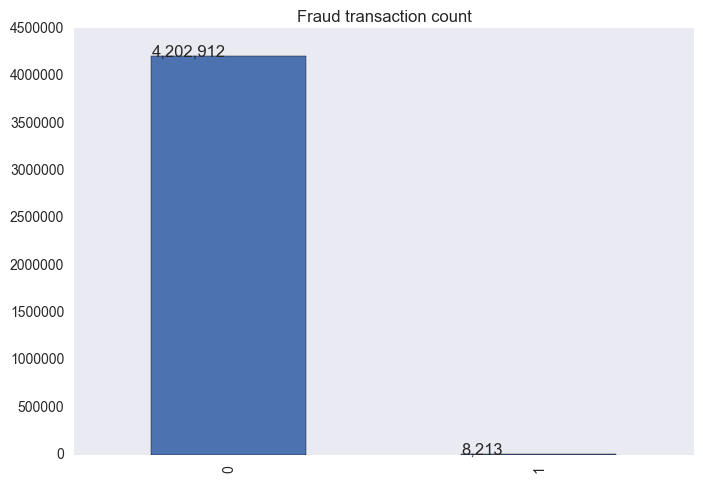

In [6]:
ax = pd.value_counts(data['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

In [7]:
#removing for cols: 'nameOrig','nameDest'
non_numeric_cols = ['nameOrig','nameDest','Unnamed: 0','step']
data = drop_columns(data,non_numeric_cols)

In [8]:
rel_types = ['CASH_OUT','TRANSFER']

In [9]:
data = data[(data['type'] ==rel_types[0]) | (data['type'] ==rel_types[1]) ]

In [10]:
for type_col in rel_types:
    data = add_binary_col(data,'type',type_col,type_col)

In [11]:
data = drop_columns(data,'type')

In [12]:
normalized_cols = list(data.columns.values)

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data)

In [14]:
normalized_data = pd.DataFrame(normalized_data,columns=normalized_cols)

In [15]:
y_col = 'isFraud'

In [16]:
train = normalized_data.sample(frac=0.8,random_state=np.random.RandomState(3))
y_train = train[y_col]
x_train = drop_columns(train,[y_col])

In [17]:
test=normalized_data.drop(train.index)
y_test = test[y_col]
x_test = drop_columns(test,[y_col])
dat_true=normalized_data[normalized_data.isFraud==1]
data_train_true = dat_true.sample(frac=0.8,random_state=np.random.RandomState(3))
test_true=dat_true.drop(data_train_true .index)
dat_false=normalized_data[normalized_data.isFraud==0]
data_train_false = dat_false.sample(frac=0.8,random_state=np.random.RandomState(3))
test_false=dat_false.drop(data_train_false .index)

In [18]:
new_train = data_train_true.append(data_train_false, ignore_index=True)
# new_train= shuffle(new_train)
y_train = new_train[y_col]
x_train = drop_columns(new_train,y_col)
new_test = test_true.append(test_false,ignore_index=True)
# new_test= shuffle(new_test)
y_test = new_test[y_col]
x_test = drop_columns(new_test,y_col)


In [28]:
sum(1-y_test)/len(y_test)

0.99703473493093075

In [26]:
sum(x_test[x_test['isFlaggedFraud'] == 1])

4

In [27]:
y_test[x_test['isFlaggedFraud'] == 1]

1424    1.0
1483    1.0
1554    1.0
1615    1.0
Name: isFraud, dtype: float64

In [80]:
# # new_data_train_false = data_train_false.sample(frac=0.8,random_state=np.random.RandomState(3))
# new_train = data_train_true.append(new_data_train_false, ignore_index=True)
# # new_train= shuffle(new_train)
# y_train = new_train[y_col]
# x_train = drop_columns(new_train,y_col)
# new_test = test_true.append(test_false,ignore_index=True)
# # new_test= shuffle(new_test)
# y_test = new_test[y_col]
# x_test = drop_columns(new_test,y_col)

In [37]:
# new_train = data_train_true.append(data_train_false, ignore_index=True)
# y_train = new_train[y_col]
# x_train = drop_columns(new_train,y_col)
# new_test = test_true.append(test_false,ignore_index=True)
# y_test = new_test[y_col]
# x_test = drop_columns(new_test,y_col)

In [19]:
sm = SMOTE(kind='regular',random_state=1)
x_train, y_train = sm.fit_sample(x_train,y_train)

# Models:

### xgboost

In [20]:
xgb1 = XGBClassifier(
 objective= 'binary:logistic',
 learning_rate = 0.001,
    max_depth = 7,
 seed=27) 

In [21]:
xgb1.fit(x_train,y_train)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0,
       learning_rate=0.001, max_delta_step=0, max_depth=7,
       min_child_weight=1, n_estimators=100, nthread=-1,
       objective='binary:logistic', seed=27, silent=True, subsample=1)

In [24]:
xgb1.get_params()

{'base_score': 0.5,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.001,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'binary:logistic',
 'seed': 27,
 'silent': True,
 'subsample': 1}

In [25]:
y_hat_xgboost = xgb1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(xgb1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.751040459715
precision: 0.0109225304101
recall: 0.926354230067
f1: 0.0215904899708
f2: 0.0521529362583
Kappa : -216.375541063
tp :  1522
tn :  414616
fp :  137823
fn :  121


In [103]:
# max_depth = 7, learning_rate =0.001 
y_hat_xgboost = xgb1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(xgb1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.751040459715
precision: 0.0109225304101
recall: 0.926354230067
f1: 0.0215904899708
f2: 0.0521529362583
Kappa : -216.375541063


In [42]:
# max_depth = 7, learning_rate =0.001
y_hat_xgboost = xgb1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(xgb1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.65732869864
precision: 0.00852781592869
recall: 0.993913572733
f1: 0.0169105387969
f2: 0.0412242569284
Kappa : 107.120506872


<bound method XGBClassifier.get_params of XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0,
       learning_rate=0.001, max_delta_step=0, max_depth=7,
       min_child_weight=1, n_estimators=100, nthread=-1,
       objective='binary:logistic', seed=27, silent=True, subsample=1)>

In [22]:
pickle.dump(xgb1,open('xgb1.p','wb'))

In [23]:
xgb_test = pickle.load(open('xgb1.p', 'rb'))

In [106]:
y_hat_xgboost = xgb_test.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(xgb_test.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.751040459715
precision: 0.0109225304101
recall: 0.926354230067
f1: 0.0215904899708
f2: 0.0521529362583
Kappa : -216.375541063


In [61]:
xgb1 = XGBClassifier(
 objective= 'binary:logistic',
 learning_rate = 0.001,
    n_estimators = 100,
 seed=27) # maybe 0

In [62]:
param_test1 = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2),'learning_rate':[0.01,0.1] }
gsearch1 = RandomizedSearchCV(estimator = xgb1, param_distributions= param_test1,n_jobs= 4,
                              scoring='f1', cv=5)
gsearch1.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0,
       learning_rate=0.001, max_delta_step=0, max_depth=3,
       min_child_weight=1, n_estimators=100, nthread=-1,
       objective='binary:logistic', seed=27, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='f1', verbose=0)

In [63]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=27, silent=True,
       subsample=1)

In [64]:
y_hat_xgboost = gsearch1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(gsearch1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.749762670507
precision: 0.002967488228
recall: 0.248934875228
f1: 0.00586506058651
f2: 0.0141621479373
Kappa : 159.566521584


In [ ]:
param_test1 = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2),'learning_rate':[0.01,0.1] }
gsearch1 = RandomizedSearchCV(estimator = xgb1, param_distributions= param_test1,n_jobs= 4,
                              scoring='f1', cv=5)
gsearch1.fit(x_train,y_train)

In [ ]:
gsearch1.best_estimator_

In [ ]:
y_hat_xgboost = gsearch1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(gsearch1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

In [42]:
param_test1 = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2) }
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1,n_jobs= 4,
                              scoring='f1', cv=5)
gsearch1.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0,
       learning_rate=0.001, max_delta_step=0, max_depth=3,
       min_child_weight=1, n_estimators=100, nthread=-1,
       objective='binary:logistic', seed=27, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [43]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0,
       learning_rate=0.001, max_delta_step=0, max_depth=9,
       min_child_weight=1, n_estimators=100, nthread=-1,
       objective='binary:logistic', seed=27, silent=True, subsample=1)

In [44]:
###### n_estimators = 100 , scoring = f (instead of average_precision) , ratio = 0.82
y_hat_xgboost = gsearch1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(gsearch1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.75374222588
precision: 0.0109985780203
recall: 0.922702373707
f1: 0.0217380394181
f2: 0.0524901667498
Kappa : 158.657915105


In [ ]:
xgb1 = XGBClassifier(
 objective= 'binary:logistic',
 learning_rate = 0.001,
    n_estimators = 100,
    max_depth = 7,
    silent = False,
 seed=27) # maybe 0

In [22]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0,
       learning_rate=0.001, max_delta_step=0, max_depth=7,
       min_child_weight=1, n_estimators=100, nthread=-1,
       objective='binary:logistic', seed=27, silent=True, subsample=1)

In [23]:
###### n_estimators = 100 , scoring = f (instead of average_precision)
y_hat_xgboost = gsearch1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(gsearch1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.751506094766
precision: 0.0109357587087
recall: 0.92574558734
f1: 0.0216161673583
f2: 0.0522117028361
Kappa : -365.059263943


In [23]:
###### n_estimators = 150 , scoring = f (instead of average_precision)
y_hat_xgboost = gsearch1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(gsearch1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.751995192047
precision: 0.010964153988
recall: 0.926354230067
f1: 0.0216718045835
f2: 0.0523426967838
Kappa : -1262.86902122


In [49]:
##### n_estimators = 100
y_hat_xgboost = gsearch1.predict_proba(x_test)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(gsearch1.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.753661010464
precision: 0.0110233593688
recall: 0.925136944614
f1: 0.0217871169337
f2: 0.052609354774
Kappa : 168.932956727


In [46]:
#xgb1 wih n_estimators=100,seed=27 (smote ratio = 0.45)
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(model.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.998671676755
precision: 0.904549509367
recall: 0.617163724893
f1: 0.733719247467
f2: 0.659040686338
Kappa : 0.733077230192


In [23]:
#smote -same as before
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(model.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.657054371014
precision: 0.008505664355
recall: 0.992087644553
f1: 0.0168667218543
f2: 0.0411182136028
Kappa : 116.58117373


In [23]:
new_test = pd.DataFrame(y_test)
new_test['y_hat_xgboost'] = pd.DataFrame(model.predict(x_test))
get_stats(new_test,'isFraud','y_hat_xgboost')

accuracy: 0.998610313997
precision: 0.904541241891
recall: 0.594035301278
f1: 0.717119764879
f2: 0.637825120899
Kappa : 0.716453185901


### NN

In [45]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2))
clf.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [46]:
y_hat_nn = clf.predict_proba(x_test)

In [41]:
new_test['y_hat_nn'] = pd.DataFrame(clf.predict(x_test))
get_stats(new_test,'isFraud','y_hat_nn')

accuracy: 0.779512779697
precision: 0.0115580699806
recall: 0.867924528302
f1: 0.022812350024
f2: 0.0548676788586
Kappa : -461.250589816


In [47]:
precision_xgboost, recall_xgboost, _ = precision_recall_curve(y_test, y_hat_xgboost[:,1])
average_precision_xgboost = average_precision_score(y_test, y_hat_xgboost[:,1])
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_hat_nn[:,1])
average_precision_nn = average_precision_score(y_test, y_hat_nn[:,1])
plt.figure()
plt.plot(recall_xgboost, precision_xgboost,color = 'r',
         label='Precision-recall xgboost (area = '+str(round(average_precision_xgboost,4))+')')
plt.plot(recall_nn, precision_nn, color = 'b',
        label='Precision-recall NN (area = '+str(round(average_precision_nn,4))+')')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left",fontsize='small')
plt.savefig('precision-recall_curve.jpg')
plt.close()